# Краткий обзор ансамблевых методов

На сегодняшнем занятии, мы продолжим изучать [*ансамблевые методы*](https://en.wikipedia.org/wiki/Ensemble_learning) ([здесь](https://neurohive.io/ru/osnovy-data-science/ansamblevye-metody-begging-busting-i-steking/) можно ознакомиться с хорошим обзором). Напомню, что данные методы основаны на гипотезе о том, что объединение нескольких алгоритмов может привести к созданию одной более сильной модели. Алгоритмы, из которых будет состоять итоговая модель, принято называть *базовыми моделями (алгоритмами)*. 

В большинстве случаев, базовые алгоритмы входящие в композицию являются одинаковыми (например, каждый базовый алгоритм [*случайного леса*](https://ru.wikipedia.org/wiki/Random_forest) - это [*решающее дерево*](https://en.wikipedia.org/wiki/Decision_tree)). Но это не всегда так. Существуют методы, базовые алгоритмы которых имеют абсолютно разную структуру.

Можно выделить 3 основных типа ансамблевых методов:

1. [*Бэггинг*](https://en.wikipedia.org/wiki/Bootstrap_aggregating). Частным случаем *бэггинга* является *случайный лес*. *Бэггинг*, как правило, состоит из одинаковых базовых алгоритмов, которые строятся параллельно и независимо друг от друга, а итоговый результат является усреднением результатов всех алгоритмов

$$
a(\mathbf{x}) = \frac{1}{N}\sum\limits_{i = 1}^{N}a_{i}(\mathbf{x}) \text{ - в случае задачи регрессии},
$$

$$
a(\mathbf{x}) = \text{sgn}\Bigg(\frac{1}{N}\sum\limits_{i = 1}^{N}a_{i}(\mathbf{x})\Bigg) \text{ - в случае задачи классификации}.
$$ 

Такие подходы в основном направлены на уменьшение *разброса* модели:

$$
\mathbf{\varepsilon}^{*} = \underbrace{\Big(a - \mathbb{E}a^{*}\Big)^{2}}_{\text{Квадрат смещения}} + \underbrace{\mathbb{D}a^{*}}_{\text{Разброс}} + \underbrace{\sigma^{2}}_{\text{Шум}}, 
$$

где *смещение* - это отклонение, усредненного прогноза рассматриваемой модели (по различным обучающим выборкам) от прогноза идеальной модели;  *разброс* - показывает насколько разными могут получаться предсказания, если обучать алгоритм на разных обучающих выборках; *шум* - характеристика данных, которая будет наблюдаться даже на идеальной модели. 


2. [*Бустинг*](https://en.wikipedia.org/wiki/Boosting_(machine_learning)). Данный подход так же характеризуется одинаковыми базовыми алгоритмами. Но, в отличие от *бэггинга*, *бустинг* представляет собой направленное построение, в котором модели строятся последовательно и каждая следующая направлена на уменьшение ошибки уже построенной композиции. Наиболее распространенной реализацией *бустинга* является [*градиентный бустинг*](https://en.wikipedia.org/wiki/Gradient_boosting), который на каждой итерации шагает в сторону антиградиента ошибки, полученной по уже построенной композиции алгоритмов. 

Если основная цель *бэггинга* уменьшить *разброс*, то *бустинг* направлен на получение модели с более низким *смещением*.   


3. [*Стекинг*](https://dyakonov.org/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/). В данном случае, базовые алгоритмы, как правило, различны. Самая простая реализация *стэкинга* следующая:


   - Выборка делится на 3 части;
   - На первой части обучаются базовые алгоритмы;
   - На второй части делается прогноз каждого обученного на первой части базового алгоритма;
   - На полученных прогнозах обучается финальная модель (данная модель не является композицией базовых алгоритмов. Это независимый от них алгоритм, который использует их предсказания в качестве фичей.);
   - На третьей части тестируется качество финальной модели.

Такой подход к реализации стекинга называется *блендингом*. Очевидный недостаток *блендинга* - разделение выборки на части для обучения (имееются ввиду первые 2 части). Для повышения качества финальной модели можно построить несколько *блендингов* на разных разбиениях и усреднить результаты базовых алгоритмов, полученные на этих разбиениях. 

*Блендинг* - это одноуровневая реализация *стэкинга*. Существуют более сложные подходы к реализации - многоуровневые. Например, в случае двухуровнего *стэкинга*, можно взять *блэндинг* от *блэндинга*:

   - Выборка делится на 4 части;
   - На первой части обучаются базовые алгоритмы;
   - На второй части делается прогноз каждого обученного на первой части базового алгоритма;
   - На полученных прогнозах обучаются другие базовые алгоритмы;
   - На третьей части делается прогноз каждого обученного на второй части базового алгоритма;
   - На полученных на третьей части прогнозах обучается финальная модель;
   - На четвертой части тестируется качество финальной модели.
   
   
   
На прошлом занятии Вам уже рассказывали о *бэггинге* и его частном случае - *случайном лесе*. Большая часть этого занятия будет посвящена *градиентному бустингу*.

# Градиентный бустинг

### 1. Постановка задачи в общем виде

Пусть у нас имеется обучающая выборка 

$$\Big\{\mathbf{x}_{j}, y_{j}\Big\}_{j = 1}^{n}$$ 

где $\mathbf{x}_{j} = \Big(x_{j}^{1}, \ldots, x_{j}^{m}\Big)$ - вектор значений признаков на $j$-ом объекте, а $y_{j}$ - ответ на данном объекте. Через $\mathbf{x}$ обозначим матрицу, строками которой являются вектора $\mathbf{x}_{j}$.

Будем строить композицию в виде

$$
a(\mathbf{x}) = a_{0}(\mathbf{x}) + \sum\limits_{i = 1}^{N}a_{i}(\mathbf{x}).
$$

Перед началом построения необходимо задать начальный алгоритм $a_{0}(\mathbf{x})$. Поскольку построение направленное, алгоритм $a_{0}(\mathbf{x})$ можно взять сколько угодно простым. Например,

$$
a_{0}(\mathbf{x}) = \frac{1}{n}\sum\limits_{j = 1}^{n}y_{j} \text{ - в случае задачи регрессии}
$$

или

$$
a_{0}(\mathbf{x}) = \mathbf{I}\Bigg[\frac{1}{n}\sum\limits_{j = 1}^{n}y_{j} \ge 0.5\Bigg] \text{ - в случае задачи классификации},
$$

где $\mathbf{I}$ - индикаторная функция.

Пусть построено $(N - 1)$ алгоритмов:

$$
a^{(N - 1)}(\mathbf{x}) = a_{0}(\mathbf{x}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x})
$$

и функционал ошибки имеет вид:

$$
Q\Big(a^{(N - 1)}(\mathbf{x}), \mathbf{x}\Big) = \frac{1}{n}\sum\limits_{j = 1}^{n}L\Big(y_{j}, a^{(N - 1)}(\mathbf{x}_{j})\Big) = \frac{1}{n}\sum\limits_{j = 1}^{n}L\Bigg(y_{j}, a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j})\Bigg).
$$

Необходимо выбрать алгоритм $a_{N}(\mathbf{x})$ таким образом, чтобы ошибка была минимальной:


$$
Q\Big(a^{(N)}(\mathbf{x}), \mathbf{x}\Big)  = \frac{1}{n}\sum\limits_{j = 1}^{n}L\Bigg(y_{j}, a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N}a_{i}(\mathbf{x}_{j})\Bigg) = \\ = \frac{1}{n}\sum\limits_{j = 1}^{n}L\Bigg(y_{j}, \Big[a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j})\Big] + a_{N}(\mathbf{x}_{j})\Bigg) \to \min_{a_{N}}.
$$


Из предыдущих занятий мы помним, что направление наискорейшего убывания функции определяется ее *антиградиентом*:

$$
\mathbf{w_{N}} = \mathbf{w_{N - 1}} - \nabla Q(\mathbf{w}_{N - 1}, \mathbf{x}).
$$

В нашем случае,

$$
\mathbf{w_{N}} = 
\begin{bmatrix}
    \Big(a_{0}(\mathbf{x}_{1}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{1})\Big) + a_{N}(\mathbf{x}_{1})\\
    \vdots \\
    \Big(a_{0}(\mathbf{x}_{n}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{n})\Big) + a_{N}(\mathbf{x}_{n})\\
\end{bmatrix} \quad \mathbf{w_{N - 1}} = 
\begin{bmatrix}
    a_{0}(\mathbf{x}_{1}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{1})\\
    \vdots \\
    a_{0}(\mathbf{x}_{n}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{n})\\
\end{bmatrix}, \quad \nabla Q(\mathbf{w}_{N - 1}, \mathbf{x}) = 
\begin{bmatrix}
    L_{z}^{'}(y_{1}, z)\Bigg|_{z = a_{0}(\mathbf{x}_{1}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{1})}\\
    \vdots \\
    L_{z}^{'}(y_{n}, z)\Bigg|_{z = a_{0}(\mathbf{x}_{n}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{n})}
\end{bmatrix}
$$


Из этого следует, что

$$
a_{N}(\mathbf{x}_{j}) = -L_{z}^{'}(y_{j}, z)\Bigg|_{z = a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j})}
$$

Таким образом, мы получили, что новый алгоритм $a_{N}$ должен принимать на каждом объекте $\mathbf{x}_{j}$ свое значение. Соответственно, нам необходимо найти функцию $\tilde{a}(\mathbf{x})$, которая является наилучшей аппроксимацией функции $a_{N}(\mathbf{x})$ относительно некоторой функции потерь $\tilde{L}(y, z)$. А это задача обучения с учителем, в которой в качестве обучающей выборки выступает множество $\Bigg\{\mathbf{x}_{j}, -L_{z}^{'}(y_{j}, z)\Bigg|_{z = a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j})}\Bigg\}$.

Заметим, что выбор функции потерь $\tilde{L}(y, z)$ не зависит от выбора исходной функции потерь $L(y, z)$, вся информация о которой содержится в векторе антиградиента.    

### 2. Градиентный бустинг для задач регрессии и классификации

1. *Задача регрессии.*

В задаче регрессии в качестве функции потерь, как правило, используется *квадратичная функция* потерь:

$$
L\Big(y_{i}, a(\mathbf{x}_{i})\Big) = \Big(y_{i} - a(\mathbf{x}_{i})\Big)^{2}.
$$

В этом случае, вектор антиградиента на $N$ - ой итерации примет вид:

$$
\begin{bmatrix}
    -L_{z}^{'}(y_{1}, z)\Bigg|_{z = a_{0}(\mathbf{x}_{1}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{1})}\\
    \vdots \\
    -L_{z}^{'}(y_{n}, z)\Bigg|_{z = a_{0}(\mathbf{x}_{n}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{n})}
\end{bmatrix} = 
\begin{bmatrix}
    2\Bigg(y_{1} - a_{0}(\mathbf{x}_{1}) - \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{1})\Bigg)\\
    \vdots \\
    2\Bigg(y_{n} - a_{0}(\mathbf{x}_{n}) - \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{n})\Bigg)
\end{bmatrix} = 
\begin{bmatrix}
    2\Big(y_{1} - a^{(N - 1)}(\mathbf{x}_{1})\Big)\\
    \vdots \\
    2\Big(y_{n} - a^{(N - 1)}(\mathbf{x}_{n})\Big)
\end{bmatrix}
$$

Если же мы имеем дело с *абсолютной функцией* потерь:

$$
L\Big(y_{i}, a(\mathbf{x}_{i})\Big) = \Big|y_{i} - a(\mathbf{x}_{i})\Big|,
$$

то вектор антиградиента на $N$ - ой итерации примет вид:

$$
\begin{bmatrix}
    \frac{\Big(y_{1} - a^{(N - 1)}(\mathbf{x}_{1})\Big)}{\Big|y_{1} - a^{(N - 1)}(\mathbf{x}_{1})\Big|}\\
    \vdots \\
    \frac{\Big(y_{n} - a^{(N - 1)}(\mathbf{x}_{n})\Big)}{\Big|y_{n} - a^{(N - 1)}(\mathbf{x}_{n})\Big|}
\end{bmatrix} = 
\begin{bmatrix}
    \text{sgn}\Big(y_{1} - a^{(N - 1)}(\mathbf{x}_{1})\Big)\\
    \vdots \\
    \text{sgn}\Big(y_{n} - a^{(N - 1)}(\mathbf{x}_{n})\Big)
\end{bmatrix}
$$


2. *Задача классификации.*

При решении задачи классификации, в качестве функции потерь обычно используется логистическая функция 

$$
L\Big(y_{i}, a(\mathbf{x}_{i})\Big) = \ln{\Big(1 + e^{-y_{i}a(\mathbf{x}_{i})}\Big)}.
$$

В данном случае, вектор антиградиента на $N$ - ой итерации примет вид:

$$
\begin{bmatrix}
    -L_{z}^{'}(y_{1}, z)\Bigg|_{z = a^{(N - 1)}(\mathbf{x}_{1})\Big)}\\
    \vdots \\
    -L_{z}^{'}(y_{n}, z)\Bigg|_{z = a^{(N - 1)}(\mathbf{x}_{n})\Big)}
\end{bmatrix} =
\begin{bmatrix}
    \frac{y_{1}}{1 + \text{exp}\Big(-y_{1}a^{(N - 1)}(\mathbf{x}_{1})\Big)}\\
    \vdots \\
    \frac{y_{n}}{1 + \text{exp}\Big(-y_{n}a^{(N - 1)}(\mathbf{x}_{n})\Big)}
\end{bmatrix}
$$

### 3. Решающие деревья в качестве базовых алгоритмов градиентного бустинга

В градиентном бустинге в качестве базовых алгоритмов обычно используются неглубокие *решающие деревья*. 

Как мы помним, дерево разбивает пространство объектов на $K$ частей, где $K$ - количество листовых вершин. Все объекты, попавшие в один и тот же лист, получают одинаковый прогноз. Таким образом, математическая формализация *решающего дерева* может выглядеть следующим образом:

$$
a(\mathbf{x}_{j}) = \sum\limits_{i = 1}^{K}\mathbf{I}\Big[\mathbf{x}_{j} \in \text{Leaf}_{i}\Big] \cdot a_{i}, 
$$

где $a_{i}$ - значение в $i$-ом листе и

$$
\mathbf{I}\Big[\mathbf{x}_{j} \in \text{Leaf}_{i}\Big] = \begin{cases}
1, \text{ если объект } \mathbf{x}_{j} \text{ попал в i-ый лист}\\
0, \text{ иначе}.
\end{cases}
$$

Тогда очередной базовый алгоритм $a_{N}$ и вся композиция могут быть переписаны в следующем виде:

$$
a_{N}(\mathbf{x}_{j}) = \sum\limits_{i = 1}^{K_{N}}\mathbf{I}\Big[\mathbf{x}_{j} \in \text{Leaf}_{i}\Big] \cdot a_{N,i}, 
$$

$$
a^{(N)}(\mathbf{x}_{j}) = a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{K_{N}}\mathbf{I}\Big[\mathbf{x}_{j} \in \text{Leaf}_{i}\Big] \cdot a_{N, i}.
$$

И задача оптимизации примет вид:

$$
\frac{1}{n}\sum\limits_{j = 1}^{n}L\Bigg(y_{j}, \Big[a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j})\Big] + \sum\limits_{i = 1}^{K_{N}}\mathbf{I}\Big[\mathbf{x}_{j} \in \text{Leaf}_{i}\Big] \cdot a_{N,i}\Bigg) \to \min_{a_{N,1}\ldots,a_{N, K_{N}}}.
$$

Поскольку 

$$
\Big\{\mathbf{x}_{j} \in \text{Leaf}_{i}\Big\} \cap \Big\{\mathbf{x}_{j} \in \text{Leaf}_{m}\Big\}  = \emptyset, \quad \forall i, m: i\neq m,
$$

то данная задача разбивается на $K_{N}$ независимых подзадач

$$
\begin{cases}
\sum\limits_{\mathbf{x}_{j} \in \text{Leaf}_{1}}L\Bigg(y_{j}, \Big[a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j})\Big] + a_{N, 1}\Bigg) &\to& \min_{a_{N, 1}},\\
\qquad \qquad \qquad \qquad \ldots \\
\sum\limits_{\mathbf{x}_{j} \in \text{Leaf}_{K_{N}}}L\Bigg(y_{j}, \Big[a_{0}(\mathbf{x}_{j}) + \sum\limits_{i = 1}^{N - 1}a_{i}(\mathbf{x}_{j})\Big] + a_{N, K_{N}}\Bigg) &\to& \min_{a_{N, K_{N}}}.\\
\end{cases}
$$

Решение данной задачи можно найти аналитически.

**Задача:** Найти решение в случае задачи регресии и квадратичной функции потерь.

### 4. Переобучение градиентного бустинга

Посмотрим как меняется ошибка алгоритма в зависимости от количества деревьев

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Сгенирируем случайную выборку
X, Y = datasets.make_regression(n_samples = 2000, n_features = 20, n_informative = 10, random_state = 911) 

#Разделим выборку на две части 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import numpy as np

gb = GradientBoostingRegressor(n_estimators = 500, max_depth = 5, learning_rate = 1, random_state = 123)
gb.fit(X_train, Y_train)

rmse_test = [np.sqrt(metrics.mean_squared_error(Y_test, predict)) for predict in gb.staged_predict(X_test)]
rmse_train = np.sqrt(gb.train_score_)

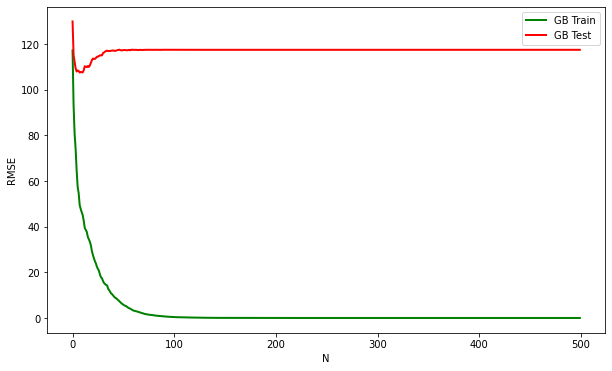

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10, 6))

plt.plot(rmse_train, linewidth = 2, color = 'green', label = 'GB Train')
plt.plot(rmse_test, linewidth = 2, color = 'red', label = 'GB Test')

plt.legend(loc = 'upper right')
plt.xlabel("N", fontsize = 10)
plt.ylabel("RMSE", fontsize = 10)

plt.show()

Из графика видно, что с увеличением числа деревьев ошибка стремится к 0. При этом ошибка на тестовой выборке заметно выше. Достигнув минимума, она начинает расти. Таким образом, произошло переобучение модели.

Один из способов борьбы с переобучением - двигаться в сторону антиградиента с некоторым шагом:

$$
a(\mathbf{x}) = a_{0}(\mathbf{x}) + \eta\sum\limits_{i = 1}^{N}a_{i}(\mathbf{x}),
$$

где $\eta \in (0, 1]$ - длина шага.

**Вопрос:** Каковы причины переобучения?

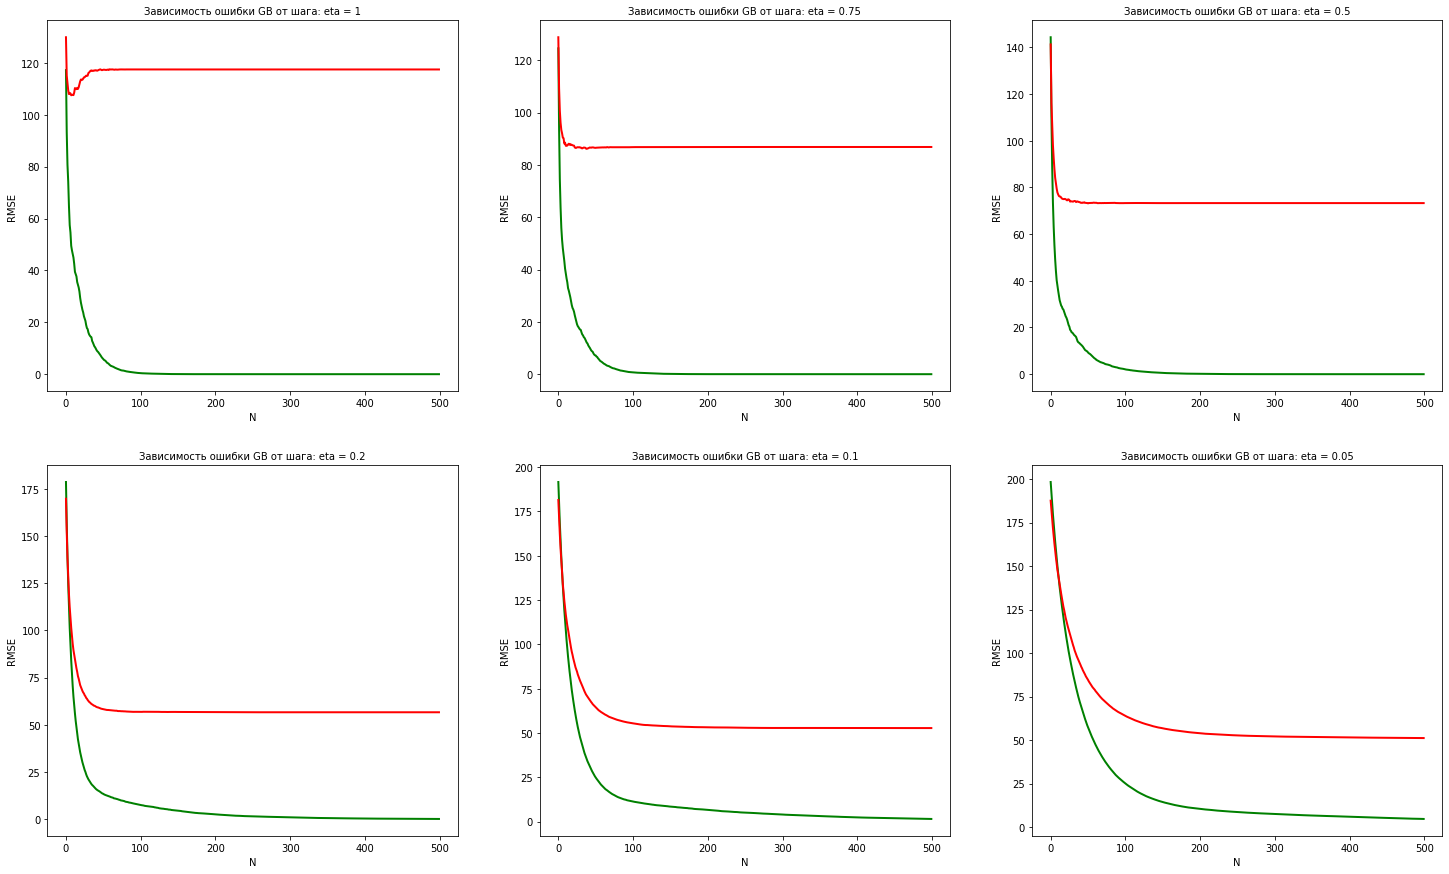

In [4]:
fig, axs = plt.subplots(figsize = (25, 15), nrows = 2, ncols = 3)

for ind, eta in enumerate([1, 0.75, 0.5, 0.2, 0.1, 0.05]):
    gb = GradientBoostingRegressor(n_estimators = 500, max_depth = 5, learning_rate = eta, random_state = 123)
    gb.fit(X_train, Y_train)

    rmse_test = [np.sqrt(metrics.mean_squared_error(Y_test, predict)) for predict in gb.staged_predict(X_test)]
    rmse_train = np.sqrt(gb.train_score_)
        
    axs[ind//3][ind%3].plot(rmse_train, linewidth = 2, color = 'green', label = 'GB Train')
    axs[ind//3][ind%3].plot(rmse_test, linewidth = 2, color = 'red', label = 'GB Test')
    axs[ind//3][ind%3].set_title("Зависимость ошибки GB от шага: eta = {s[0]}".format(s = [eta]), fontsize = 10)
    axs[ind//3][ind%3].set_xlabel("N", fontsize = 10)
    axs[ind//3][ind%3].set_ylabel("RMSE", fontsize = 10)
    
plt.show()

Из представленных выше результатов можно увидеть, что уменьшение размера шага позволяет уменьшить ошибку на тестовой выборке. При этом есть и неприятный момент - чем меньше шаг, тем ниже скорость сходимости.

Другой метод борьбы с переобучением - *стохастический градиентный бустинг*. В данном случае, каждый из алгоритмов обучается не на всей выборке, а лишь на какой - то ее части, которая выбирается случайным образом для каждого из алгоритмов.

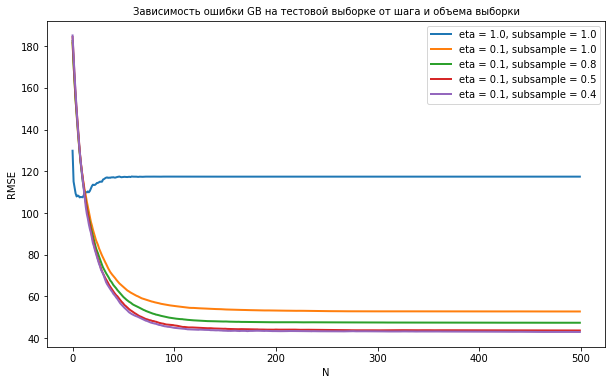

In [5]:
plt.figure(figsize = (10, 6))

etaList = [1.0, 0.1, 0.1, 0.1, 0.1]
subsampleList = [1.0, 1.0, 0.8, 0.5, 0.4]

rmse_testList = []
rmse_trainList = []

for eta, subsample in zip(etaList, subsampleList):
    gb = GradientBoostingRegressor(n_estimators = 500, max_depth = 5, 
                                   learning_rate = eta, subsample = subsample, random_state = 123)
    gb.fit(X_train, Y_train)
    
    rmse_test = [np.sqrt(metrics.mean_squared_error(Y_test, predict)) for predict in gb.staged_predict(X_test)]
    rmse_testList.append(rmse_test)
    
    rmse_trainList.append(np.sqrt(gb.train_score_[-1]))
    
    plt.plot(rmse_test, linewidth = 2, label = 'eta = {s[0]}, subsample = {s[1]}'.format(s = [eta, subsample]))

plt.title("Зависимость ошибки GB на тестовой выборке от шага и объема выборки", fontsize = 10)
plt.legend(loc = 'upper right')
plt.xlabel("N", fontsize = 10)
plt.ylabel("RMSE", fontsize = 10)
    
plt.show()

In [6]:
for rmse_train, rmse_test, eta, subsample in zip(rmse_trainList, rmse_testList, etaList, subsampleList):
    print('eta = {s[0]}, subsample = {s[1]}: RMSE TRAIN = {s[2]}   RMSE TEST = {s[3]}   (RMSE TEST - RMSE TRAIN) = {s[4]}'.\
         format(s = [eta, subsample, 
                     round(rmse_train, 4), 
                     round(rmse_test[-1], 4), 
                     round(rmse_test[-1], 4) - round(rmse_train, 4)
                    ]))

eta = 1.0, subsample = 1.0: RMSE TRAIN = 0.0003   RMSE TEST = 117.4376   (RMSE TEST - RMSE TRAIN) = 117.43730000000001
eta = 0.1, subsample = 1.0: RMSE TRAIN = 1.5171   RMSE TEST = 52.7967   (RMSE TEST - RMSE TRAIN) = 51.2796
eta = 0.1, subsample = 0.8: RMSE TRAIN = 0.768   RMSE TEST = 47.3957   (RMSE TEST - RMSE TRAIN) = 46.6277
eta = 0.1, subsample = 0.5: RMSE TRAIN = 1.1214   RMSE TEST = 43.6891   (RMSE TEST - RMSE TRAIN) = 42.5677
eta = 0.1, subsample = 0.4: RMSE TRAIN = 1.3286   RMSE TEST = 42.9693   (RMSE TEST - RMSE TRAIN) = 41.640699999999995


По полученным данным видно, что при уменьшении объема выборки для обучения каждого базового алгоритма, ошибка на обучении становится выше. При этом, обобщающая способность модели возрастает - переобучение становится меньше.

### 5. Определение оптимальных гиперпараметров

*Гиперпараметры* - это параметры модели, значения которых не оптимизируются в процессе построения. Они настраиваются заранее, а для того, чтобы подобрать оптимальные значения гиперпараметров, необходимо проводить многократное обучение модели на разных значениях таких параметров и выбирать оптимальные. 

Рассмотренные выше параметры - количество деревьев, размер шага, объем выборки для построения каждого нового алгоритма в композиции - всё это гиперпараметры модели. Также гиперпараметром является максимальная глубина дерева.

Существует несколько способов определения оптимальных значений таких параметров. Подробнее о них мы поговорим позже. Сейчас же рассмотрим результат работы одного из них - [*полный поиск по сетке(GridSearchCV)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

Суть метода следующая: 
- Определяется список гиперпараметров, которые нужно подобрать;
- Для каждого гиперпараметра задается множество возможных значений;
- Строится декартово произведение заданных множеств;
- Для каждого элемента декартова произведения строится модель и оценивается ее качество по выбранной метрике;
- После этого выбирается комбинация гиперпараметров, ошибка на которых минимальна.

Недостаток данного подхода заключается в том, что он может быть очень времязатратным. 

На примере ниже отбираются оптимальные значения $4$ гиперпараметров, а соответствующие им множества имеют мощности $5, 5, 4$ и $7$ соответственно. Таким образом, в ходе отбор оптимальных значений параметров, будет построено $5 \cdot 5 \cdot 4 \cdot 7 = 700$ моделей. Кроме того, качество полученных моделей проверяется на кросс - валидации. Поэтому, для получения итогового количества моделей, рассчитанное значение нужно умножить на количество фолдов. В данном случае, это $3$. В итоге, мы получили $2100$ моделей. Отсюда и следует описанный выше недостаток. 

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 5, 6, 7, 8],    
    'learning_rate': [0.2, 0.1, 0.05, 0.01], 
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

gb = GridSearchCV(GradientBoostingRegressor(random_state = 123),
                   param_grid,
                   n_jobs = -1, 
                   scoring = 'neg_mean_squared_error', 
                   cv = 3, 
                   verbose = 1)

gb.fit(X_train, Y_train)

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 15.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

Посмотрим на получившиеся оптимальные значения гиперпараметров

In [8]:
gb.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.4}

Сравним результат на оптимальных параметрах с полученным ранее

In [9]:
rmse_test_best = [np.sqrt(metrics.mean_squared_error(Y_test, predict)) for predict in gb.best_estimator_.staged_predict(X_test)]
rmse_train_best = np.sqrt(gb.best_estimator_.train_score_[-1])

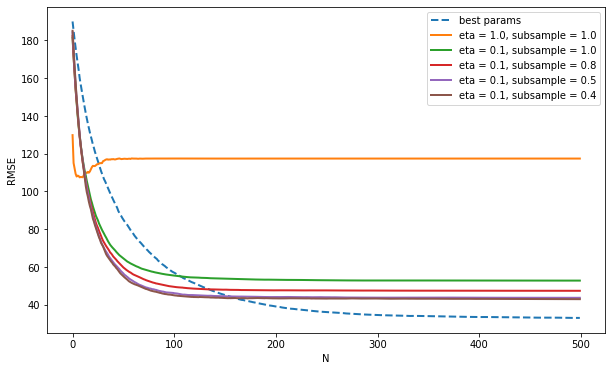

In [10]:
plt.figure(figsize = (10, 6))

plt.plot(rmse_test_best, linewidth = 2, label = 'best params'.format(s = [eta, subsample]), linestyle = '--')


for rmse_test, eta, subsample in zip(rmse_testList, etaList, subsampleList):
    plt.plot(rmse_test, linewidth = 2, label = 'eta = {s[0]}, subsample = {s[1]}'.format(s = [eta, subsample]))

plt.legend(loc = 'upper right')
plt.xlabel("N", fontsize = 10)
plt.ylabel("RMSE", fontsize = 10)
    
plt.show()

In [11]:
print('               best params: RMSE TRAIN = {s[0]}   RMSE TEST = {s[1]}   (RMSE TEST - RMSE TRAIN) = {s[2]}'.\
     format(s = [round(rmse_train_best, 4), 
                 round(rmse_test_best[-1], 4), 
                 round(rmse_test_best[-1] - rmse_train_best, 4)
                ]))

for rmse_train, rmse_test, eta, subsample in zip(rmse_trainList, rmse_testList, etaList, subsampleList):
    print('eta = {s[0]}, subsample = {s[1]}: RMSE TRAIN = {s[2]}   RMSE TEST = {s[3]}   (RMSE TEST - RMSE TRAIN) = {s[4]}'.\
         format(s = [eta, subsample, 
                     round(rmse_train, 4), 
                     round(rmse_test[-1], 4), 
                     round(rmse_test[-1] - rmse_train, 4)
                    ]))

               best params: RMSE TRAIN = 7.9466   RMSE TEST = 33.0329   (RMSE TEST - RMSE TRAIN) = 25.0863
eta = 1.0, subsample = 1.0: RMSE TRAIN = 0.0003   RMSE TEST = 117.4376   (RMSE TEST - RMSE TRAIN) = 117.4373
eta = 0.1, subsample = 1.0: RMSE TRAIN = 1.5171   RMSE TEST = 52.7967   (RMSE TEST - RMSE TRAIN) = 51.2795
eta = 0.1, subsample = 0.8: RMSE TRAIN = 0.768   RMSE TEST = 47.3957   (RMSE TEST - RMSE TRAIN) = 46.6277
eta = 0.1, subsample = 0.5: RMSE TRAIN = 1.1214   RMSE TEST = 43.6891   (RMSE TEST - RMSE TRAIN) = 42.5677
eta = 0.1, subsample = 0.4: RMSE TRAIN = 1.3286   RMSE TEST = 42.9693   (RMSE TEST - RMSE TRAIN) = 41.6407


Получили, что качество на оптимальных параметрах заметно выше того, что мы получали при случайном подборе.

### 6. Сравнение бустинга со случаным лесом

Посмотрим какое качество дает *случайный лес* при значении параметров, оптимальных для *градиентного бустинга*.

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = gb.best_params_['max_depth'],
                           n_estimators = gb.best_params_['n_estimators'],
                           random_state = 123)

rf.fit(X_train, Y_train)

rmse_test_rf = np.sqrt(metrics.mean_squared_error(Y_test, rf.predict(X_test)))
rmse_train_rf =np.sqrt(metrics.mean_squared_error(Y_train, rf.predict(X_train)))

In [13]:
for rmse_train, rmse_test, name in zip([rmse_train_best, rmse_train_rf],
                                       [rmse_test_best[-1], rmse_test_rf],
                                       ['       GB best params:',
                                        'RF best params for GB:']):

    print('{s[0]} RMSE TRAIN = {s[1]}   RMSE TEST = {s[2]}   (RMSE TEST - RMSE TRAIN) = {s[3]}'.\
         format(s = [name,
                     round(rmse_train, 4), 
                     round(rmse_test, 4), 
                     round(rmse_test - rmse_train, 4)
                    ]))

       GB best params: RMSE TRAIN = 7.9466   RMSE TEST = 33.0329   (RMSE TEST - RMSE TRAIN) = 25.0863
RF best params for GB: RMSE TRAIN = 112.4472   RMSE TEST = 114.3697   (RMSE TEST - RMSE TRAIN) = 1.9226


*Случайные лес* на тех же параметрах, что и бустинг показывает качество значительно ниже. Найдем оптимальные параметры для *леса*.

In [14]:
param_grid = {
    'n_estimators': [20, 50, 100, 200, 300, 400, 500],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
}

rf = GridSearchCV(RandomForestRegressor(random_state = 123),
                   param_grid,
                   n_jobs = -1, 
                   scoring = 'neg_mean_squared_error', 
                   cv = 3, 
                   verbose = 1)

rf.fit(X_train, Y_train)

Fitting 3 folds for each of 77 candidates, totalling 231 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=123,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [15]:
rf.best_params_

{'max_depth': 15, 'n_estimators': 500}

In [16]:
rmse_test_rf_best = np.sqrt(metrics.mean_squared_error(Y_test, rf.best_estimator_.predict(X_test)))
rmse_train_rf_best = np.sqrt(metrics.mean_squared_error(Y_train, rf.best_estimator_.predict(X_train)))

In [17]:
for rmse_train, rmse_test, name in zip([rmse_train_best, rmse_train_rf, rmse_train_rf_best],
                                       [rmse_test_best[-1], rmse_test_rf, rmse_test_rf_best],
                                       ['       GB best params:',
                                        'RF best params for GB:',
                                        '       RF best params:']):

    print('{s[0]} RMSE TRAIN = {s[1]}   RMSE TEST = {s[2]}   (RMSE TEST - RMSE TRAIN) = {s[3]}'.\
         format(s = [name,
                     round(rmse_train, 4), 
                     round(rmse_test, 4), 
                     round(rmse_test - rmse_train, 4)
                    ]))

       GB best params: RMSE TRAIN = 7.9466   RMSE TEST = 33.0329   (RMSE TEST - RMSE TRAIN) = 25.0863
RF best params for GB: RMSE TRAIN = 112.4472   RMSE TEST = 114.3697   (RMSE TEST - RMSE TRAIN) = 1.9226
       RF best params: RMSE TRAIN = 32.1185   RMSE TEST = 78.5415   (RMSE TEST - RMSE TRAIN) = 46.423


Посмотрим сколько шагов потребовалось градиентному бустингу, чтобы достичь качества, полученное случайным лесом.

In [18]:
np.where(rmse_test_best > rmse_test_rf_best)[0][-1]

58

Из полученных данных можно сделать следующие выводы:

- Для получения оптимального качества с помощью случайного леса необходимо обучать базовые алгоритмы (деревья), глубина которых на порядок выше чем в случае градиентного бустинга;


- Из - за того, что процесс построения композиции ненаправленный, для получения оптимального качества приходится обучать большое количество деревьев. При этом итоговое качество, в большинстве случаев, сильно ниже чем качество, полученное с помощью градиентного бустинга.  

### 7. Популярные алгоритмы градиентного бустинга

На сегодняшний день наибольшей популярностью пользуются три метода: 
- [**XGBoost**](https://xgboost.readthedocs.io/en/latest/index.html) - самая ранняя из рассматриваемых библиотек. При разбиении каждой вершины дерева предварительно сортирует значения всех признаков участвующих в построении данного дерева. После этого для каждого признака определяет оптимальное разбиение на основе [*критерия информативности*](https://en.wikipedia.org/wiki/Information_gain_ratio). Далее выбирает признак с наилучшим разбиением. Не умеет работать с категориальными признаками. В случае, если они числовые, рассматривает их как вещественные переменные. Если передать текстовые данные - упадет. Дерево строится до указанной глубины (гиперпараметр *max_depth*), после чего происходит стрижка деревьев ([pruning](https://en.wikipedia.org/wiki/Decision_tree_pruning)).


- [**LightGBM**](http://devdoc.net/bigdata/LightGBM-doc-2.2.2/index.html) - основан на двух эвристиках: $\text{GOOS (Gradient-based One-Side Sampling)}$ и $\text{ERF (Exclusive Feature Bundling)}$. Первая заключается в том, что перед построением очередного алгоритма (дерева) считается градиент на каждом объекте. После этого объекты сортируются по абсолютному значению расчитанного градиента от большего к меньшему. Затем для разбиения вершины дерева берется $N$ объектов с наибольшим значением градиента и какая - то часть от оставшихся наблюдений. Второе свойство заключается в склейке нескольких разреженных признаков в один. В результате признаков становится меньше, что увеличивает скорость разбиения вершины. Умеет работать с категориальными фичами, предварительно закодированными числовым типом. Для этого параметру *categorical_feature* нужно передать названия таких признаков.


- [**CatBoost**](https://catboost.ai/) - это библиотека градиентного бустинга, созданная Яндексом. Использует симметричное построение деревьев, т.е. при разбиении узлов на одном уровне используются одинаковые условия. *CatBoost*  достаточно гибок при работе с категориальными признаками, позволяя использовать их без предварительной обработки. Более того, рекомендуется их не обрабатывать, так как это может повлиять на качество работы алгоритма. Для того, чтобы модель понимала какие признаки являются категориальными используется параметр *cat_features*, в который передаются индексы соответствующих столбцов. В отличие от *LightGBM* неважно каким типом данных представлен категориальный признак: числовым или текстовым. Глубина деревьев ограничена 16.

Более подробно о реализации данных методов можно прочесть в документации по приведенным ссылкам. 

Названия основных гиперпараметров для *XGBoost* и *LightGBM* преимущественно совпадают. Для *CatBoost* могут немного отличаться.
 
|**Интерпретация**                                 |**XGBoost**           |**LightGBM**                       |**Catboost** |
|:------------------------------------------------:|:--------------------:|:---------------------------------:|:-----------:|
|*Количество деревьев*                             |n_estimators          |n_estimators                       |iterations   |
|*Максимальная глубина*                            |max_depth             |max_depth                          |depth        | 
|*Шаг (скорость) обучения*                         |learning_rate (eta)   |learning_rate (eta)                |learning_rate|
|*Доля объектов для обучения одного дерева*        |subsample             |subsample (bagging_fraction)       |             |
|*Доля признаков для обучения одного дерева*       |colsample_bytree      |colsample_bytree (feature_fraction)|rsm          |
|*Минимальное количество наблюдений в листе дерева*|min_child_weight      |min_data_in_leaf                   |             |
|*Минимальное уменьшение значения функции потерь*  |gamma (min_split_loss)|min_gain_to_split (min_split_gain) |             |
|*L1 коэффициент регуляризации*                    |reg_alpha (alpha)     |reg_alpha (lambda_l1)              |             |
|*L2 коэффициент регуляризации*                    |reg_lambda (lambda)   |reg_lambda (lambda_l2)             |reg_lambda   |
|*Индексы категориальных признаков*                |                      |                                   |cat_features |
|*Названия категориальных признаков*               |                      |categorical_feature                |             |


Перед тем, как переходить к сравнению данных методов, опишем подробнее какие подходы существуют для отбора оптимальных значений гиперпараметров.

### 8. Методы подбора гиперпараметров

Выше мы уже начинали говорить о методах определения оптимальных значений гиперпараметров и рассмотрели один из возможных подходов. Обсудим подробнее этот и другие подходы, а также посмотрим какие преимущества и недостатки есть у каждого из них.

- [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) - проходится по всем узлам сетки (декартово произведение заданных множеств гиперпараметров) и выбирает оптимальный узел в зависимости от заданной метрики качества.

     **+** проход по всем узлам указанной сетки. Это гарантирует нахождение оптимального набора гиперпараметров на указанных подмножествах;
     
     **+** возможность параллельного вычисления.

     **-** занимает очень много времени;

     **-** не учитывает переобучение.


- [**RandomizedSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) - устроен схожим образом, что и метод GridSearchCV, но, в данном случае, рассматриваются уже не все узлы сетки, а лишь их часть, отобранная случайным образом. Количество узлов задается параметром $\text{n_iter}$ (по дефолту равен $10$).

     **+** полезен, когда количество гиперпараметров велико и/или мощности указанных подмножеств для поиска оптимума большие.
     
     **+** возможность параллельного вычисления.

     **-** существует вероятность пропустить оптимальную комбинацию настраиваемых параметров;

     **-** несмотря на то, что данный метод гораздо быстрее вышеуказанного аналога, он так же может быть очень времязатратным;

     **-** не учитывает переобучение.


- **Последовательная настройка гиперпараметров** - заключается в последовательной фиксации всех гиперпараметров за исключением одного, подбора оптимального значения варьируемого параметра и переходу к исследованию следующего.

     **+** время работы: количество комбинаций настраиваемых параметров, которые необходимо проверить, равно сумме размерностей множеств допустимых (заданных) значений гиперпараметров;

     **+** как следствие из вышеуказанного преимущества - возможность рассматривать множества допустимых значений большей мощности.

     **-**  небольшой набор проверяемых комбинаций гиперпараметров, тем самым, вероятность пропустить оптимальную комбинацию еще выше.


- [**Генетический метод**](https://en.wikipedia.org/wiki/Genetic_algorithm) - идея алгоритма основана на эволюционном учении и триаде Ч. Дарвина: *наследственность, изменчивость и естественный отбор*. 

     В файле **"GeneticBoost.py"** реализован генетический алгоритм для решения задачи **классификации** и алгоритмов **XGBoost**, **LightGBM** и **CatBoost**. Суть метода заключается в следующих простых шагах:

     1. Инициализация родителей 
     2. Оценка качества каждого родителя текущего поколения
     3. Отбор лучших родителей из текущего поколения
     4. Скрещивание лучших родителей текущего поколения - создание детей
     5. Мутация детей
     6. Получение нового поколения: лучшие родители текущего поколения + их дети
     7. Переход к шагу 2 или завершение работы алгоритма

   Ниже будет приведен пример использования данного алгоритма. 
     
    **+** время работы: гораздо быстрее поиска по сетке;
    
    **+** в случае, если в качестве метрики выбран *roc_auc_score* - учитывает переобучение;

    **-**  не гарантирует нахождения оптимума, во многом зависит от стартовых родителей.
    
    
- [**Hyperopt**](https://github.com/hyperopt/hyperopt) - метод байесовской оптимизации гиперпараметров. На каждом шаге, проверяемая комбинация гиперпараметров определяется с учетом результатов, полученных на предыдущих шагах. Для этого решается задача поиска компромисса между *изучением* и *применением* (*explore-exploit dilemma*): выбрать точку из пространства параметров, где ожидаемое значение оптимизируемой функции оптимально (*применение*) или из пространства с большой неопределенностью (*изучение*). Оптимизируемая функция аппроксимируется посредством апостериорного гауссовского процесса.    




|**Интерпретация**                                 |**Наиболее часто используемые значения**            |
|:------------------------------------------------:|:--------------------------------------------------:|
|*Количество деревьев*                             |$\text{list(range(10,  121, 10))}$                  |
|*Максимальная глубина*                            |$\text{list(range(4,  10))}$                         | 
|*Шаг (скорость) обучения*                         |$\text{[0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}$|
|*Доля объектов для обучения одного дерева*        |$\text{[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}$     |
|*Доля признаков для обучения одного дерева*       |$\text{[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}$     |
|*Минимальное количество наблюдений в листе дерева*|$\text{[1, 5, 10, 20, 30, 50, 100]}$                |
|*Минимальное уменьшение значения функции потерь*  |$\text{[0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1]}$|
|*L1 коэффициент регуляризации*                    |$\text{[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ]}$     |
|*L2 коэффициент регуляризации*                    |$\text{[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ]}$     |
 

### 9. Сравнение XGBoost, LightGBM и CatBoost

**Постановка задачи:**

Предположим, что некоторый оператор сотовой связи решил поднять тариф, чтобы повысить свою прибыль. Поднимать тариф всем клиентам довольно рискованно, так как многие из них могут уйти к конкурентам. На основании исторических данных по повышению тарифа, необходимо определить группу клиентов, которые останутся после увеличения стоимости обслуживания. 

**Целевая переменная:**
- $\text{TARGET}$ - продолжит ли клиент пользоваться услугами связи в течение года после увеличения стоимости обслуживания.


**Признаки:**
- $\text{AVG_PAYMENT_COMP_3_6}$ - сгруппированное некоторым образом отношение среднего платежа за последние 3 месяца к среднему платежу за предыдущие три (категориальный порядковый признак)


- $\text{SHARE_PAYMENT_MNT12(6, 3, 2)}$ - доля месяцев, в которые были совершены платежи среди последних 12 (6, 3, 2) 


- $\text{AVG_PAYMENT_12}$ - среднемесячный платеж клиента, расчитанный по последнему году 


- $\text{DURATION_INC}$ - во сколько раз увеличиваем продолжительность бесплатных минут разговора


- $\text{VALUE_INC}$ - на сколько увеличиваем стоимость тарифа


- $\text{VALUE_INC2}$ - отношение величины увеличения к текущей стоимости обслуживания


- $\text{SMS_INC}$ - на сколько % увеличится количество бесплатных SMS


- $\text{PAY_LAST_MNT}$ - наличие платежа за последние 30 дней (бинарный признак)

##### Загружаем данные

In [19]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Читаем данные и выводим первые пять строк на экран
data = pd.read_csv('mobile.csv', sep = ',')
data.head(5)

,TARGET,AVG_PAYMENT_COMP_3_6,PAY_LAST_MNT,SHARE_PAYMENT_MNT12,SHARE_PAYMENT_MNT6,SHARE_PAYMENT_MNT3,SHARE_PAYMENT_MNT2,AVG_PAYMENT_12,VALUE_INC,VALUE_INC2,SMS_INC,DURATION_INC
0,1,2,0,0.250000,0.166667,0.333333,0.0,2200.0,150.0,0.753769,10.0,0.683468
1,1,8,0,0.416667,0.333333,0.333333,0.5,NaN,150.0,0.717703,10.0,0.737903
2,1,10,1,1.000000,1.000000,1.000000,1.0,NaN,70.0,0.244727,13.0,0.552778
3,0,1,0,0.166667,0.166667,0.000000,0.0,4000.0,60.0,0.142857,12.4,0.900000
4,1,9,1,1.000000,1.000000,1.000000,1.0,4000.0,40.0,0.224490,7.0,0.610000


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44200 entries, 0 to 44199
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TARGET                44200 non-null  int64  
 1   AVG_PAYMENT_COMP_3_6  44200 non-null  int64  
 2   PAY_LAST_MNT          44200 non-null  int64  
 3   SHARE_PAYMENT_MNT12   44200 non-null  float64
 4   SHARE_PAYMENT_MNT6    44200 non-null  float64
 5   SHARE_PAYMENT_MNT3    44200 non-null  float64
 6   SHARE_PAYMENT_MNT2    44200 non-null  float64
 7   AVG_PAYMENT_12        40546 non-null  float64
 8   VALUE_INC             44200 non-null  float64
 9   VALUE_INC2            44200 non-null  float64
 10  SMS_INC               44200 non-null  float64
 11  DURATION_INC          44200 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 4.0 MB


In [21]:
# Заменим пропуски на медиану
data['AVG_PAYMENT_12'].fillna(round(data['AVG_PAYMENT_12'].median()), inplace = True)

X = data.drop(['TARGET'], 1)
Y = data['TARGET']
#Разделим выборку на две части 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

##### XGBoost
Инициализация параметров

In [22]:
numberOfParents = 10 # Количество родителей на старте
numberOfGenerations = 10 # Количество поколений, которое будет создано
numberOfParentsMating = 4 # Количество родителей, которые останутся после каждого этапа эволюции
numberOfChildren = 6 # Количество детей от каждого поколения

In [23]:
# Метрика, по которой будем выбирать лучший набор гиперпараметров
metric = 'roc_auc_adj'

# Список метрик, на которые хотом смотреть (также можно добавить 'f1' и 'accuracy')
metricList = ['roc_auc', 'recall', 'precision']

# коэффициент регуляризации: roc_auc_adj = roc_auc(test) - overfitting / coef_adj
coef_adj = 10.0

In [24]:
# набор гиперпараметов, которые будем подбирать
# каждому гиперпараметру соответствует 3 числа: мин. и макс. значение и шаг
hyperparameterSettings = {'n_estimators': [10, 121, 5],
                          'max_depth': [3, 11, 1],
                          'learning_rate': [0.001, 0.3002, 0.002],
                          'colsample_bytree': [0.4, 1.0, 0.1],
                          'subsample': [0.4, 1.0, 0.1],
                          'reg_lambda': [0.05, 0.35, 0.05]}

# Словарь поколений: 
# ключ - номер поколения, 
# элемент - словарь, ключи которого - имена родителей/детей, а значения - набор гиперпараметров в лексикографическом порядке
population = {}

# Словарь метрик поколений: 
# ключ - номер поколения, 
# элемент - словарь, ключи которого - имена родителей/детей, а значения - результаты метрик в лексикографическом порядке
scorePopulation = {}

Инициализация генетического алгоритма

In [25]:
import GeneticBoost as gboost
import random

# Водные данные:
# Количество родителей и набор гиперпараметров
random.seed(237)
population['Gender 0'] = gboost.initilialize_poplulation(numberOfParents, hyperparameterSettings)

            colsample_bytree  learning_rate  max_depth  n_estimators  \
Parents 1                0.7          0.003        8.0          35.0   
Parents 2                0.9          0.183        9.0         100.0   
Parents 3                0.9          0.299        8.0          70.0   
Parents 4                0.8          0.183        5.0          50.0   
Parents 5                0.4          0.109        4.0         105.0   
Parents 6                0.5          0.149        4.0          20.0   
Parents 7                0.8          0.037        9.0          55.0   
Parents 8                0.9          0.145        6.0          20.0   
Parents 9                0.6          0.277        4.0          60.0   
Parents 10               0.7          0.027        9.0          70.0   

            reg_lambda  subsample  
Parents 1         0.25        0.8  
Parents 2         0.05        0.9  
Parents 3         0.30        0.5  
Parents 4         0.15        0.8  
Parents 5         0.05     

Отбор лучших родителей, построение нового поколения 

In [26]:
import time
start = time.time()

for generation in range(numberOfGenerations + 1):
    
    print("                                  This is number %s generation" % (generation))
    print()
    
    # Строим модель на каждом родителе и считаем метрики
    # Output: словарь с метриками - DICT(ключ - имя родителя, значение - numpy массив с метриками в лексикографическом порядке)
    scorePopulation['Gender ' + str(generation)] =\
        gboost.train_population(population['Gender ' + str(generation)], #Данные по текущему поколению
                                hyperparameterSettings, #Набор гиперпараметров с допустимыми значениями
                                X_train, Y_train, #Данные для обучения
                                X_test, Y_test, #Данные для теста
                                metric, # Основная метрика (на основе которой будут выбираться "лучшие" родители)
                                metricList, #Список метрик на которые также хотим смотреть
                                alg = 'XGB',
                                coef_adj = coef_adj) 
    
    print()
    print('Best parents in generation %s: ' % (generation), end = '')
         
    # Отбор "лучших" родителей  
    # Output: список лучших родителей - LIST
    bestParents =\
        gboost.new_parents_selection(scorePopulation['Gender ' + str(generation)], # Расчитанные метрики для текущего поколения 
                                    numberOfParentsMating, #Количество родителей, которые останутся
                                    metricList, #Список метрик на которые также хотим смотреть
                                    metric)# Основная метрика
    
    if(generation < numberOfGenerations):
        
        # Скрещивание "лучших" родителей
        # Output: словарь детей - DICT(ключ - имя ребенка, значение - numpy массив с гиперпараметрами в лексикографическом порядке)
        children =\
            gboost.crossover_uniform(bestParents, #"лучшие" родители 
                                     population['Gender ' + str(generation)], #Словарь родителей текущего поколения 
                                     numberOfChildren, #Количество детей
                                     generation) # Номер текущего поколения (нужен для именования детей)

        # Мутация детей
        gboost.mutation(children, #словарь детей
                        hyperparameterSettings, #Множество допустимых значений для каждого гиперпараметра
                        2) #Количество гиперпараметров для мутации

        print()
        print()
        print('New generation: ')

        # Получение нового поколения: "лучшие" родители + дети
        # Output: Словарь родителей нового поколения - DICT(ключ - имя родителя, значение - numpy массив с гиперпараметрами 
                                                                                       #в лексикографическом порядке)
        population['Gender ' + str(generation + 1)] =\
            gboost.getNewPopulation(population['Gender ' + str(generation)], # Текущее поколение со значениями их параметров
                                    children, # Дети со значениями их параметров
                                    bestParents, # Имена "лучших" родителей
                                    list(sorted(hyperparameterSettings.keys()))) # Названия гиперпараметров

        print('\n\n\n\n\n\n')
       
    # Печать на экран лучшего алгоритам
    if(generation == numberOfGenerations):
        gboost.printBestAlgorithm(bestParents[0],
                                scorePopulation['Gender ' + str(generation)][bestParents[0]],
                                metricList, metric,
                                list(sorted(hyperparameterSettings.keys())),
                                population['Gender ' + str(generation)][bestParents[0]])


print('\n')
time_genetic_xgb = (time.time() - start) / 60.0
print(f"Time = {time_genetic_xgb}")

                                  This is number 0 generation

           Train precision Train recall Train roc_auc Train roc_auc_adj  \
Parents 1         0.826058     0.891441      0.874847          0.873143   
Parents 10        0.833452     0.893419      0.889641          0.886715   
Parents 2         0.885955     0.910303      0.944085          0.934445   
Parents 3         0.868755     0.895802      0.923602          0.915748   
Parents 4         0.824924      0.89783      0.881639          0.879666   
Parents 5         0.822128     0.895954        0.8755          0.874115   
Parents 6         0.816942     0.886573      0.860834          0.859889   
Parents 7         0.831357     0.899351      0.892036          0.888897   
Parents 8         0.824446     0.892962       0.87635          0.874808   
Parents 9         0.824371     0.897019      0.880119          0.878218   

           Test precision Test recall Test roc_auc Test roc_auc_adj  
Parents 1        0.820899    0.883201    

                  Train precision Train recall Train roc_auc  \
Children 1 (gen2)        0.823592     0.896004       0.88057   
Children 2 (gen2)        0.824103     0.896309      0.880792   
Children 3 (gen0)        0.820165      0.89423      0.871666   
Children 3 (gen1)        0.822229     0.896106      0.876059   
Children 3 (gen2)        0.825228     0.893976      0.879062   
Children 4 (gen2)        0.827792     0.892557      0.883457   
Children 5 (gen2)        0.852127      0.90579      0.918313   
Children 6 (gen2)        0.821043     0.895396      0.875245   
Parents 4                0.824924      0.89783      0.881639   
Parents 5                0.822128     0.895954        0.8755   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen2)          0.878695       0.817608    0.888166     0.861819   
Children 2 (gen2)          0.878947       0.815564    0.887102      0.86234   
Children 3 (gen0)          0.870593       0.816889    0.88

                  Train precision Train recall Train roc_auc  \
Children 1 (gen4)        0.819497     0.898945      0.876706   
Children 1 (gen5)        0.825967      0.89641      0.884118   
Children 2 (gen2)        0.824103     0.896309      0.880792   
Children 2 (gen5)        0.855823     0.901734      0.919015   
Children 3 (gen5)        0.817812     0.877649      0.860151   
Children 4 (gen3)        0.822857     0.894788      0.878579   
Children 4 (gen5)        0.820676     0.894788      0.868242   
Children 5 (gen5)        0.822126      0.89641      0.877209   
Children 6 (gen2)        0.821043     0.895396      0.875245   
Children 6 (gen5)        0.831069     0.893266      0.889287   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen4)          0.875254       0.814655    0.893723     0.862187   
Children 1 (gen5)          0.881795       0.818866    0.887694     0.860885   
Children 2 (gen2)          0.878947       0.815564    0.88

                  Train precision Train recall Train roc_auc  \
Children 1 (gen4)        0.819497     0.898945      0.876706   
Children 1 (gen8)        0.865279     0.906652      0.929036   
Children 2 (gen8)         0.82037     0.896866      0.874793   
Children 3 (gen8)        0.831887     0.898996      0.893583   
Children 4 (gen3)        0.822857     0.894788      0.878579   
Children 4 (gen6)        0.821626     0.896157      0.878113   
Children 4 (gen8)        0.821943     0.893419      0.874812   
Children 5 (gen5)        0.822126      0.89641      0.877209   
Children 5 (gen8)        0.819729     0.893672      0.868248   
Children 6 (gen8)         0.82571     0.883278       0.86949   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen4)          0.875254       0.814655    0.893723     0.862187   
Children 1 (gen8)          0.921433       0.822461    0.867478     0.853005   
Children 2 (gen8)          0.873509       0.816782    0.89

**Замечание.** Данные метод **не возвращает** модель на оптимальных значениях гиперпараметров. По полученным значениям ее нужно будет построить.

##### LightGBM
Инициализация параметров 

- Количество родителей, детей, "лучших" родителей и поколений - оставляем теми же. 
- Также не изменяем метрики и набор допустимых значений гиперпараметров.
- Исходное поколение берем то же самое

In [27]:
# Словарь поколений: 
# ключ - номер поколения, 
# элемент - словарь, ключи которого - имена родителей/детей, а значения - набор гиперпараметров в лексикографическом порядке
population = {'Gender 0': population['Gender 0']}

# Словарь метрик поколений: 
# ключ - номер поколения, 
# элемент - словарь, ключи которого - имена родителей/детей, а значения - результаты метрик в лексикографическом порядке
scorePopulation = {}

Отбор лучших родителей, построение нового поколения 

In [28]:
start = time.time()

for generation in range(numberOfGenerations + 1):
    
    print("                                  This is number %s generation" % (generation))
    print()
    
    # Строим модель на каждом родителе и считаем метрики
    # Output: словарь с метриками - DICT(ключ - имя родителя, значение - numpy массив с метриками в лексикографическом порядке)
    scorePopulation['Gender ' + str(generation)] =\
        gboost.train_population(population['Gender ' + str(generation)], #Данные по текущему поколению
                                hyperparameterSettings, #Набор гиперпараметров с допустимыми значениями
                                X_train, Y_train, #Данные для обучения
                                X_test, Y_test, #Данные для теста
                                metric, # Основная метрика (на основе которой будут выбираться "лучшие" родители)
                                metricList, #Список метрик на которые также хотим смотреть
                                alg = 'LightGBM',
                                coef_adj = coef_adj,
                                cat_feat = ['AVG_PAYMENT_COMP_3_6']) 
    
    print()
    print('Best parents in generation %s: ' % (generation), end = '')
         
    # Отбор "лучших" родителей  
    # Output: список лучших родителей - LIST
    bestParents =\
        gboost.new_parents_selection(scorePopulation['Gender ' + str(generation)], # Расчитанные метрики для текущего поколения 
                                    numberOfParentsMating, #Количество родителей, которые останутся
                                    metricList, #Список метрик на которые также хотим смотреть
                                    metric)# Основная метрика
    
    if(generation < numberOfGenerations):
        
        # Скрещивание "лучших" родителей
        # Output: словарь детей - DICT(ключ - имя ребенка, значение - numpy массив с гиперпараметрами в лексикографическом порядке)
        children =\
            gboost.crossover_uniform(bestParents, #"лучшие" родители 
                                     population['Gender ' + str(generation)], #Словарь родителей текущего поколения 
                                     numberOfChildren, #Количество детей
                                     generation) # Номер текущего поколения (нужен для именования детей)

        # Мутация детей
        gboost.mutation(children, #словарь детей
                        hyperparameterSettings, #Множество допустимых значений для каждого гиперпараметра
                        2) #Количество гиперпараметров для мутации

        print()
        print()
        print('New generation: ')

        # Получение нового поколения: "лучшие" родители + дети
        # Output: Словарь родителей нового поколения - DICT(ключ - имя родителя, значение - numpy массив с гиперпараметрами 
                                                                                       #в лексикографическом порядке)
        population['Gender ' + str(generation + 1)] =\
            gboost.getNewPopulation(population['Gender ' + str(generation)], # Текущее поколение со значениями их параметров
                                    children, # Дети со значениями их параметров
                                    bestParents, # Имена "лучших" родителей
                                    list(sorted(hyperparameterSettings.keys()))) # Названия гиперпараметров

        print('\n\n\n\n\n\n')
       
    # Печать на экран лучшего алгоритам
    if(generation == numberOfGenerations):
        gboost.printBestAlgorithm(bestParents[0],
                                scorePopulation['Gender ' + str(generation)][bestParents[0]],
                                metricList, metric,
                                list(sorted(hyperparameterSettings.keys())),
                                population['Gender ' + str(generation)][bestParents[0]])


print('\n')
time_genetic_lgbm = (time.time() - start) / 60.0
print(f"Time = {time_genetic_lgbm}")

                                  This is number 0 generation

           Train precision Train recall Train roc_auc Train roc_auc_adj  \
Parents 1         0.637427            1      0.873936          0.872467   
Parents 10        0.822404     0.904219      0.887421          0.884671   
Parents 2         0.869025      0.90432      0.932087          0.923978   
Parents 3         0.863902     0.897982      0.924974          0.917544   
Parents 4         0.821925     0.898692      0.880248          0.878361   
Parents 5         0.823708     0.892455      0.876454          0.875093   
Parents 6         0.817337      0.88779      0.862932          0.861959   
Parents 7         0.822964     0.903458      0.887849          0.884995   
Parents 8         0.819435     0.897881      0.873389           0.87191   
Parents 9          0.82583     0.892911      0.880135          0.878192   

           Test precision Test recall Test roc_auc Test roc_auc_adj  
Parents 1        0.637934           1    

                  Train precision Train recall Train roc_auc  \
Children 1 (gen2)        0.826264     0.892962      0.880367   
Children 2 (gen0)        0.822691     0.893064      0.876059   
Children 2 (gen2)        0.859985     0.900974      0.924713   
Children 3 (gen2)        0.825213     0.890528       0.87767   
Children 4 (gen2)        0.828534      0.89281      0.884097   
Children 5 (gen0)        0.825697     0.891847      0.878999   
Children 5 (gen2)        0.821495      0.89139      0.870863   
Children 6 (gen2)         0.82542     0.897323      0.885387   
Parents 4                0.821925     0.898692      0.880248   
Parents 5                0.823708     0.892455      0.876454   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen2)          0.878486       0.821922    0.885566     0.861557   
Children 2 (gen0)          0.874581       0.819226    0.885566      0.86128   
Children 2 (gen2)          0.917607       0.820493    0.86

                  Train precision Train recall Train roc_auc  \
Children 1 (gen5)        0.821715     0.892962      0.874793   
Children 2 (gen3)        0.822794     0.893926      0.876453   
Children 2 (gen5)        0.830658     0.897373      0.893472   
Children 3 (gen3)         0.82163     0.895244      0.875183   
Children 3 (gen5)        0.637427            1      0.814419   
Children 4 (gen5)         0.82077     0.893266      0.872035   
Children 5 (gen5)        0.820415     0.894128      0.870147   
Children 6 (gen3)        0.825062     0.894382      0.878968   
Children 6 (gen5)        0.828489     0.893266      0.886813   
Parents 5                0.823708     0.892455      0.876454   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen5)          0.873405       0.818608    0.888285     0.860908   
Children 2 (gen3)          0.875067       0.820096    0.888639     0.862591   
Children 2 (gen5)          0.890061       0.819019    0.88

                  Train precision Train recall Train roc_auc  \
Children 1 (gen8)        0.821668      0.89641      0.877107   
Children 2 (gen3)        0.822794     0.893926      0.876453   
Children 2 (gen8)        0.830708     0.895954      0.893818   
Children 3 (gen8)        0.827399     0.895447       0.88805   
Children 4 (gen7)        0.822794     0.893926      0.876453   
Children 4 (gen8)        0.833819     0.899097       0.89859   
Children 5 (gen8)        0.819584     0.894635       0.86968   
Children 6 (gen6)        0.823708     0.892455      0.876454   
Children 6 (gen8)        0.823689      0.89281      0.876639   
Parents 5                0.823708     0.892455      0.876454   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen8)           0.87557       0.817816     0.88994     0.861737   
Children 2 (gen3)          0.875067       0.820096    0.888639     0.862591   
Children 2 (gen8)           0.89016        0.81971    0.88

##### CatBoost
Инициализация параметров

In [29]:
hyperparameterSettings = {'iterations': [10, 121, 5],
                          'depth': [3, 11, 1],
                          'learning_rate': [0.001, 0.3002, 0.002],
                          'rsm': [0.4, 1.0, 0.1],
                          'reg_lambda': [0.05, 0.35, 0.05]}

# Словарь поколений: 
# ключ - номер поколения, 
# элемент - словарь, ключи которого - имена родителей/детей, а значения - набор гиперпараметров в лексикографическом порядке
population = {}

# Словарь метрик поколений: 
# ключ - номер поколения, 
# элемент - словарь, ключи которого - имена родителей/детей, а значения - результаты метрик в лексикографическом порядке
scorePopulation = {}

In [30]:
random.seed(238)
population['Gender 0'] = gboost.initilialize_poplulation(numberOfParents, hyperparameterSettings)

            depth  iterations  learning_rate  reg_lambda  rsm
Parents 1     9.0        25.0          0.281        0.05  0.8
Parents 2     3.0        40.0          0.261        0.15  0.4
Parents 3     8.0        10.0          0.195        0.20  0.6
Parents 4     3.0        55.0          0.199        0.10  0.8
Parents 5     4.0       115.0          0.255        0.25  0.4
Parents 6     9.0        35.0          0.291        0.20  0.9
Parents 7     4.0        25.0          0.253        0.30  0.5
Parents 8     7.0       110.0          0.211        0.10  0.4
Parents 9     7.0        55.0          0.027        0.30  0.4
Parents 10    3.0        35.0          0.107        0.05  0.8


Отбор лучших родителей, построение нового поколения 

In [31]:
start = time.time()

for generation in range(numberOfGenerations + 1):
    
    print("                                  This is number %s generation" % (generation))
    print()
    
    # Строим модель на каждом родителе и считаем метрики
    # Output: словарь с метриками - DICT(ключ - имя родителя, значение - numpy массив с метриками в лексикографическом порядке)
    scorePopulation['Gender ' + str(generation)] =\
        gboost.train_population(population['Gender ' + str(generation)], #Данные по текущему поколению
                                hyperparameterSettings, #Набор гиперпараметров с допустимыми значениями
                                X_train, Y_train, #Данные для обучения
                                X_test, Y_test, #Данные для теста
                                metric, # Основная метрика (на основе которой будут выбираться "лучшие" родители)
                                metricList, #Список метрик на которые также хотим смотреть
                                alg = 'CatBoost',
                                coef_adj = coef_adj,
                                cat_feat = [0]) 
    
    print()
    print('Best parents in generation %s: ' % (generation), end = '')
         
    # Отбор "лучших" родителей  
    # Output: список лучших родителей - LIST
    bestParents =\
        gboost.new_parents_selection(scorePopulation['Gender ' + str(generation)], # Расчитанные метрики для текущего поколения 
                                    numberOfParentsMating, #Количество родителей, которые останутся
                                    metricList, #Список метрик на которые также хотим смотреть
                                    metric)# Основная метрика
    
    if(generation < numberOfGenerations):
        
        # Скрещивание "лучших" родителей
        # Output: словарь детей - DICT(ключ - имя ребенка, значение - numpy массив с гиперпараметрами в лексикографическом порядке)
        children =\
            gboost.crossover_uniform(bestParents, #"лучшие" родители 
                                     population['Gender ' + str(generation)], #Словарь родителей текущего поколения 
                                     numberOfChildren, #Количество детей
                                     generation) # Номер текущего поколения (нужен для именования детей)

        # Мутация детей
        gboost.mutation(children, #словарь детей
                        hyperparameterSettings, #Множество допустимых значений для каждого гиперпараметра
                        2) #Количество гиперпараметров для мутации

        print()
        print()
        print('New generation: ')

        # Получение нового поколения: "лучшие" родители + дети
        # Output: Словарь родителей нового поколения - DICT(ключ - имя родителя, значение - numpy массив с гиперпараметрами 
                                                                                       #в лексикографическом порядке)
        population['Gender ' + str(generation + 1)] =\
            gboost.getNewPopulation(population['Gender ' + str(generation)], # Текущее поколение со значениями их параметров
                                    children, # Дети со значениями их параметров
                                    bestParents, # Имена "лучших" родителей
                                    list(sorted(hyperparameterSettings.keys()))) # Названия гиперпараметров

        print('\n\n\n\n\n\n')
       
    # Печать на экран лучшего алгоритам
    if(generation == numberOfGenerations):
        gboost.printBestAlgorithm(bestParents[0],
                                scorePopulation['Gender ' + str(generation)][bestParents[0]],
                                metricList, metric,
                                list(sorted(hyperparameterSettings.keys())),
                                population['Gender ' + str(generation)][bestParents[0]])


print('\n')
time_genetic_cb = (time.time() - start) / 60.0
print(f"Time = {time_genetic_cb}")

                                  This is number 0 generation

           Train precision Train recall Train roc_auc Train roc_auc_adj  \
Parents 1         0.825781     0.892607      0.879185          0.877441   
Parents 10        0.813195     0.883125       0.85024          0.849425   
Parents 2         0.822832     0.886624      0.865759          0.864943   
Parents 3         0.816019     0.890579        0.8644          0.863536   
Parents 4         0.823552     0.885813      0.867176          0.866361   
Parents 5         0.823047     0.895954      0.876249          0.874822   
Parents 6         0.830303      0.89139      0.883878           0.88153   
Parents 7         0.812647     0.896004      0.864417          0.863629   
Parents 8         0.832876     0.893266      0.888853          0.886063   
Parents 9           0.8135     0.889109      0.860761          0.859948   

           Test precision Test recall Test roc_auc Test roc_auc_adj  
Parents 1        0.819466    0.884856    

                  Train precision Train recall Train roc_auc  \
Children 1 (gen2)        0.822692     0.891188      0.871704   
Children 2 (gen2)        0.816416     0.871514      0.839502   
Children 3 (gen1)        0.826827      0.89139      0.876981   
Children 3 (gen2)        0.825785     0.892151      0.876453   
Children 4 (gen0)        0.823106     0.893723      0.875463   
Children 4 (gen2)        0.824499     0.895193      0.877179   
Children 5 (gen1)        0.822691     0.893064       0.87266   
Children 5 (gen2)        0.822026     0.887131      0.866343   
Children 6 (gen2)        0.822136     0.896004      0.875969   
Parents 5                0.823047     0.895954      0.876249   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen2)          0.870665       0.819982    0.885802     0.861315   
Children 2 (gen2)           0.83877        0.81527    0.863459     0.832178   
Children 3 (gen1)          0.875526       0.820136    0.88

                  Train precision Train recall Train roc_auc  \
Children 1 (gen4)        0.824362     0.891492      0.873545   
Children 1 (gen5)        0.833255     0.896714      0.891613   
Children 2 (gen5)        0.821911     0.884799      0.866634   
Children 3 (gen1)        0.826827      0.89139      0.876981   
Children 3 (gen5)        0.812776     0.876077      0.838137   
Children 4 (gen5)        0.824303     0.889464      0.872546   
Children 5 (gen1)        0.822691     0.893064       0.87266   
Children 5 (gen5)        0.818819     0.882466      0.863768   
Children 6 (gen2)        0.822136     0.896004      0.875969   
Children 6 (gen5)        0.836909     0.897931      0.896651   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen4)          0.872404       0.819805    0.884738     0.862129   
Children 1 (gen5)          0.888485       0.819996    0.884265     0.860336   
Children 2 (gen5)          0.865823       0.819392    0.88

                  Train precision Train recall Train roc_auc  \
Children 1 (gen4)        0.824362     0.891492      0.873545   
Children 1 (gen7)        0.827376       0.8885      0.875783   
Children 1 (gen8)        0.821189     0.894889      0.873908   
Children 2 (gen8)        0.828336     0.882517      0.870855   
Children 3 (gen1)        0.826827      0.89139      0.876981   
Children 3 (gen8)        0.823047     0.895954      0.876249   
Children 4 (gen8)        0.815994     0.866596      0.822805   
Children 5 (gen8)         0.82651     0.891593      0.878476   
Children 6 (gen2)        0.822136     0.896004      0.875969   
Children 6 (gen8)        0.824138     0.889159      0.872275   

                  Train roc_auc_adj Test precision Test recall Test roc_auc  \
Children 1 (gen4)          0.872404       0.819805    0.884738     0.862129   
Children 1 (gen7)          0.874444       0.821058    0.880364     0.862392   
Children 1 (gen8)          0.872704       0.817252    0.88

Сравнение работы алгоритмов (время работы при новом запуске может отличаться):

|                                                  |**XGBoost**           |**LightGBM**                 |**Catboost**    |
|:------------------------------------------------:|:--------------------:|:---------------------------:|:--------------:|
|*ROC AUC Score Test*                              |$0.8772$              |$0.8765$                     |$0.8760$        |
|*ROC AUC Score Train*                             |$0.8626$              |$0.8628$                     |$0.8626$        |
|*Время работы*                                    |$0.87\text{ min}$     |$0.69\text{ min}$            |$4.2\text{ min}$| 
|*Количество деревьев*                             |$45$                  |$105$                        |$115$           |
|*Максимальная глубина деревьев*                   |$5$                   |$4$                          |$4$             |
|*Шаг (скорость) обучения*                         |$0.183$               |$0.109$                      |$0.255$         |
|*Доля объектов для обучения одного дерева*        |$0.8$                 |$0.6$                        |                |
|*Доля признаков для обучения одного дерева*       |$0.4$                 |$0.4$                        |$0.5$           |
|*L2 коэффициент регуляризации*                    |$0.05$                |$0.05$                       |$0.25$          |

### 10. Сравнение алгоритмов поиска гиперпараметров

Сравним методы поиска гиперпараметров на примере алгоритма **XGBoost**

GridSearchCV

In [32]:
import xgboost as xgb

start = time.time()

param_grid = {
    'n_estimators': [20, 30, 50, 70, 100],
    'max_depth': [5, 6, 7, 8],    
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2], 
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_lambda': [0.05, 0.1, 0.3],
    'objective': ['binary:logistic'],
}

xgb_gs = GridSearchCV(xgb.XGBClassifier(random_state = 123), param_grid, n_jobs = -1, 
                   scoring = 'roc_auc', cv = 2, verbose = 1) 
xgb_gs.fit(X_train, Y_train)

print(f"Time = {(time.time() - start) / 60.0}")

Fitting 2 folds for each of 3240 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 28.9min finished


Time = 28.93917124668757


In [33]:
xgb_gs.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'reg_lambda': 0.05,
 'subsample': 1.0}

In [34]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(Y_train, xgb_gs.best_estimator_.predict_proba(X_train)[:, 1]))
print(roc_auc_score(Y_test, xgb_gs.best_estimator_.predict_proba(X_test)[:, 1]))

0.8797772275853837
0.8623772178329381


RandomizedSearchCV

In [35]:
from sklearn.model_selection import RandomizedSearchCV

start = time.time()

param_grid = {
    'n_estimators': [20, 30, 50, 70, 85, 100, 125, 150],
    'max_depth': [5, 6, 7, 8, 9],    
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'objective': ['binary:logistic'],
}

xgb_rs = RandomizedSearchCV(xgb.XGBClassifier(random_state = 23), param_grid, n_jobs = -1, 
                         scoring = 'roc_auc', cv = 2, verbose = 1, n_iter = 2000, random_state = 54) 
xgb_rs.fit(X_train, Y_train)

print(f"Time = {(time.time() - start) / 60.0}")

Fitting 2 folds for each of 2000 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 27.4min finished


Time = 27.365946638584138


In [36]:
xgb_rs.best_params_

{'subsample': 0.9,
 'reg_lambda': 0.4,
 'objective': 'binary:logistic',
 'n_estimators': 50,
 'max_depth': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [37]:
print(roc_auc_score(Y_train, xgb_rs.best_estimator_.predict_proba(X_train)[:, 1]))
print(roc_auc_score(Y_test, xgb_rs.best_estimator_.predict_proba(X_test)[:, 1]))

0.8792911680054667
0.8622130777765075


HyperOpt

In [49]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials

def hyperopt_xgb_score(params):
    
    model = xgb.XGBClassifier(n_jobs = -1)
    model.set_params(**params, random_state = 121)
    model.fit(X_train, Y_train)
    
    roc_test = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
    
    return -roc_test

In [64]:
start = time.time()

tpe_trials = Trials()

space_xgb = {
            'n_estimators': hp.choice('n_estimators', np.arange(10, 121, dtype = int)),
            'max_depth':  hp.choice('max_depth', np.arange(4, 11, dtype = int)),
            'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
            'subsample': hp.quniform('subsample', 0.3, 1.0, 0.025),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0, 0.025),
            'reg_lambda': hp.quniform('reg_lambda', 0.01, 0.5, 0.01),
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'eval_metric': 'auc'
            }



best = fmin(fn = hyperopt_xgb_score, space = space_xgb, algo = tpe.suggest, trials = tpe_trials,
            max_evals = 20, rstate = np.random.RandomState(17), show_progressbar = True)
print()
print()
print('best:')
print(best)
print(f"Time = {(time.time() - start) / 60.0}")

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

job exception: value -2 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy


  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]


XGBoostError: value -2 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy

In [63]:
tpe_trials.idxs_vals[1]['max_depth']

[4, 1, 4, 6, 0, 5, 1, 5, 3, 2, 4, 1, 4, 0, 5, 0, 1, 0, 2, 5]

Сравнение работы алгоритмов: (время работы при новом запуске может отличаться)

|                                            |**Genetic**         |**GridSearch**    |**RandomSearch** |**HyperOpt**     |
|:------------------------------------------:|:------------------:|:----------------:|:---------------:|:---------------:|
|*ROC AUC Score Train*                       |$0.8772$            |$0.8798$          |$0.8793$         |                 |
|*ROC AUC Score Test*                        |$0.8626$            |$0.8624$          |$0.8622$         |$0.8627$         |
|*Время работы*                              |$0.87\text{ min}$   |$27.9\text{ min}$ |$26.7\text{ min}$|$1.3\text{ min}$ | 
|*Количество деревьев*                       |$45$                |$100$             |$50$             |$84$             |
|*Максимальная глубина деревьев*             |$5$                 |$6$               |$6$              |$2$              |
|*Шаг (скорость) обучения*                   |$0.183$             |$0.05$            |$0.1$            |$0.194$          |
|*Доля объектов для обучения одного дерева*  |$0.8$               |$1.0$             |$0.9$            |$0.75$           |
|*Доля признаков для обучения одного дерева* |$0.4$               |$0.5$             |$0.5$            |$0.9$            |
|*L2 коэффициент регуляризации*              |$0.05$              |$0.05$            |$0.4$            |$0.05$           |